# Thesis Figures Generator

Generate publication-quality figures for the Industrial Defect Detection thesis.

**Outputs:**
- Model comparison charts
- ROC curves
- Reconstruction grids
- Anomaly heatmaps
- Dataset overview figures

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.insert(0, 'F:/Thesis')

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score

from src.config import DEVICE, MODELS_DIR, FIGURES_DIR, OUTPUTS_DIR, MVTEC_CATEGORIES, NEU_CATEGORIES, ensure_dirs
from src.data import MVTecDataset, KolektorDataset, NEUDataset
from src.data.transforms import denormalize
from src.models import create_cae, create_vae, create_denoising_ae

# Set publication style
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 11
sns.set_style('whitegrid')

ensure_dirs()
print(f"Device: {DEVICE}")

Device: cpu


## 1. Load All Results

In [2]:
# Load CSV results
cae_df = pd.read_csv(OUTPUTS_DIR / 'cae_mvtec_results.csv') if (OUTPUTS_DIR / 'cae_mvtec_results.csv').exists() else None
vae_df = pd.read_csv(OUTPUTS_DIR / 'vae_mvtec_results.csv') if (OUTPUTS_DIR / 'vae_mvtec_results.csv').exists() else None
dae_df = pd.read_csv(OUTPUTS_DIR / 'dae_mvtec_results.csv') if (OUTPUTS_DIR / 'dae_mvtec_results.csv').exists() else None
kolektor_df = pd.read_csv(OUTPUTS_DIR / 'kolektor_generalization_results.csv') if (OUTPUTS_DIR / 'kolektor_generalization_results.csv').exists() else None

print("Loaded results:")
for name, df in [('CAE', cae_df), ('VAE', vae_df), ('DAE', dae_df), ('Kolektor', kolektor_df)]:
    if df is not None:
        print(f"  {name}: {len(df)} entries")

Loaded results:
  VAE: 15 entries
  DAE: 15 entries
  Kolektor: 21 entries


## 2. Figure 1: Dataset Overview

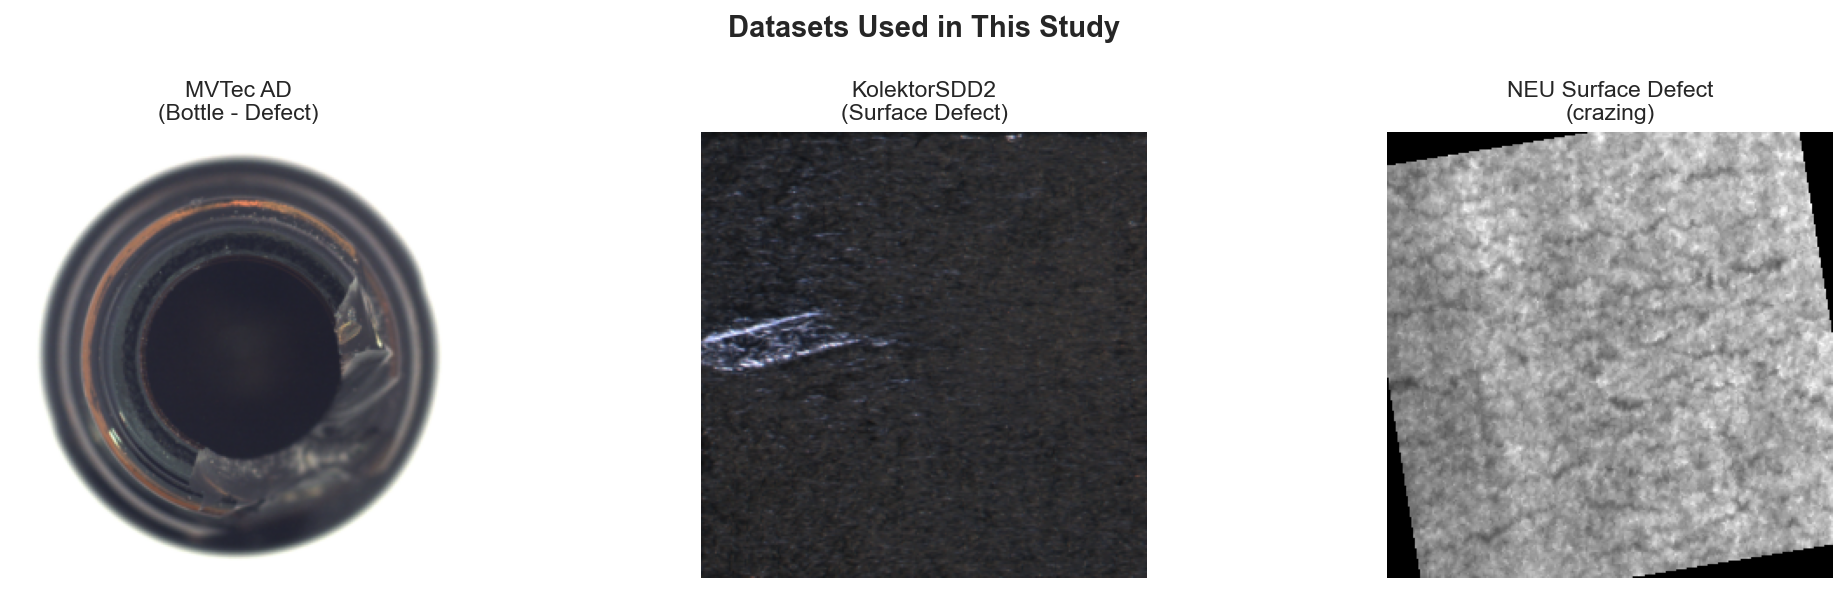

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# MVTec samples
try:
    mvtec_ds = MVTecDataset(category='bottle', split='test', return_mask=True)
    defect_idx = [i for i, l in enumerate(mvtec_ds.labels) if l == 1][0]
    img, mask, _ = mvtec_ds[defect_idx]
    img_np = denormalize(img).permute(1, 2, 0).numpy().clip(0, 1)
    axes[0].imshow(img_np)
    axes[0].set_title('MVTec AD\n(Bottle - Defect)', fontsize=11)
    axes[0].axis('off')
except Exception as e:
    axes[0].text(0.5, 0.5, 'MVTec AD', ha='center', va='center')
    axes[0].axis('off')

# Kolektor samples
try:
    kol_ds = KolektorDataset(split='test', return_mask=True)
    defect_idx = [i for i, l in enumerate(kol_ds.labels) if l == 1][0]
    img, mask, _ = kol_ds[defect_idx]
    img_np = denormalize(img).permute(1, 2, 0).numpy().clip(0, 1)
    axes[1].imshow(img_np)
    axes[1].set_title('KolektorSDD2\n(Surface Defect)', fontsize=11)
    axes[1].axis('off')
except Exception as e:
    axes[1].text(0.5, 0.5, 'Kolektor', ha='center', va='center')
    axes[1].axis('off')

# NEU samples
try:
    neu_ds = NEUDataset(split='train')
    img, label = neu_ds[0]
    img_np = denormalize(img).permute(1, 2, 0).numpy().clip(0, 1)
    axes[2].imshow(img_np)
    axes[2].set_title(f'NEU Surface Defect\n({NEU_CATEGORIES[label]})', fontsize=11)
    axes[2].axis('off')
except Exception as e:
    axes[2].text(0.5, 0.5, 'NEU', ha='center', va='center')
    axes[2].axis('off')

plt.suptitle('Datasets Used in This Study', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'thesis_fig1_datasets.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Figure 2: Model Architecture Comparison

In [4]:
# Combined results bar chart
if cae_df is not None and dae_df is not None:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    x = np.arange(len(MVTEC_CATEGORIES))
    width = 0.35
    
    cae_aucs = [cae_df[cae_df['category'] == cat]['auc'].values[0] if len(cae_df[cae_df['category'] == cat]) > 0 else 0 for cat in MVTEC_CATEGORIES]
    dae_aucs = [dae_df[dae_df['category'] == cat]['auc'].values[0] if len(dae_df[dae_df['category'] == cat]) > 0 else 0 for cat in MVTEC_CATEGORIES]
    
    bars1 = ax.bar(x - width/2, cae_aucs, width, label='CAE', color='#3498db', edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x + width/2, dae_aucs, width, label='Denoising AE', color='#e74c3c', edgecolor='black', linewidth=0.5)
    
    ax.axhline(0.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    ax.axhline(0.8, color='green', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_xlabel('MVTec AD Category', fontweight='bold')
    ax.set_ylabel('ROC-AUC Score', fontweight='bold')
    ax.set_title('Anomaly Detection Performance by Category', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(MVTEC_CATEGORIES, rotation=45, ha='right')
    ax.set_ylim(0, 1.05)
    ax.legend(loc='lower right')
    ax.grid(axis='y', alpha=0.3)
    
    # Add mean values
    ax.text(0.02, 0.95, f'CAE Mean: {np.mean(cae_aucs):.3f}', transform=ax.transAxes, fontsize=10)
    ax.text(0.02, 0.90, f'DAE Mean: {np.mean(dae_aucs):.3f}', transform=ax.transAxes, fontsize=10)
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'thesis_fig2_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

## 4. Figure 3: Cross-Dataset Generalization

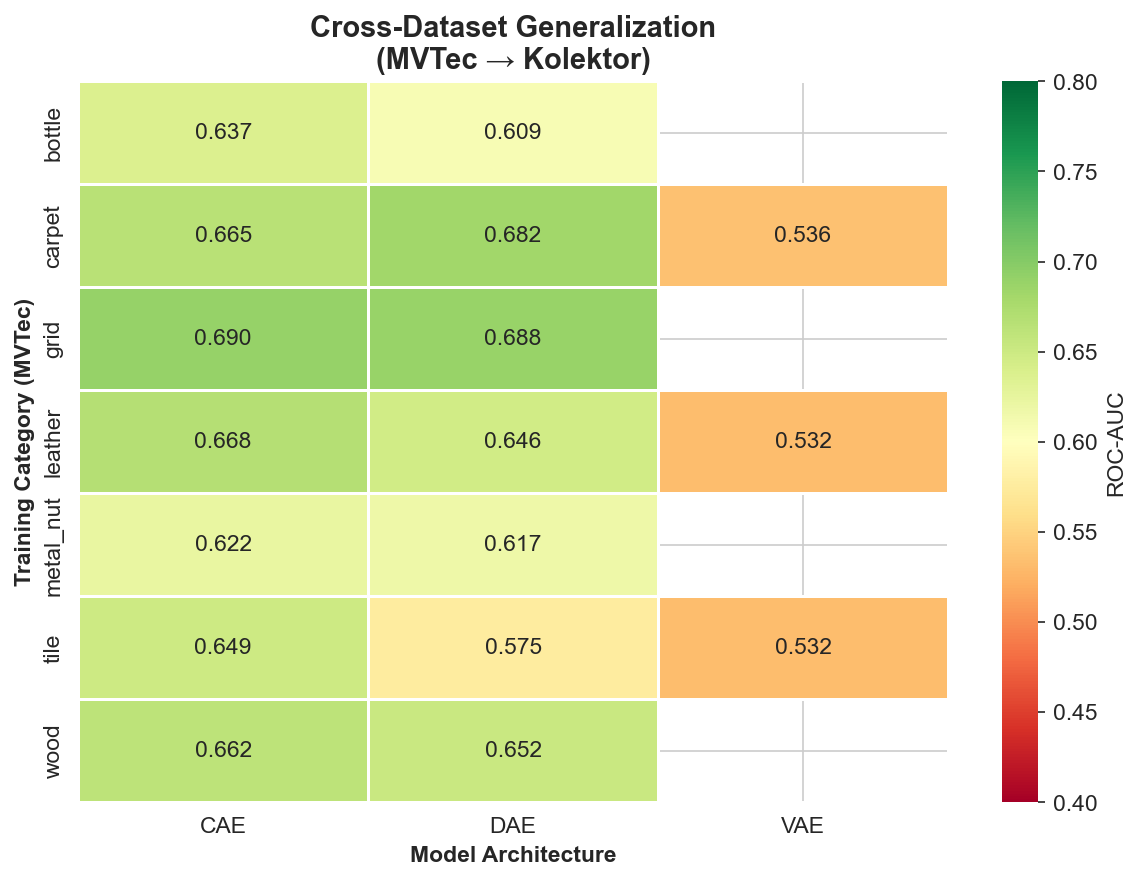

In [5]:
if kolektor_df is not None:
    # Pivot and heatmap
    pivot = kolektor_df.pivot(index='trained_on', columns='model', values='kolektor_auc')
    
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0.4, vmax=0.8, ax=ax,
                cbar_kws={'label': 'ROC-AUC'}, linewidths=0.5)
    ax.set_title('Cross-Dataset Generalization\n(MVTec → Kolektor)', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model Architecture', fontweight='bold')
    ax.set_ylabel('Training Category (MVTec)', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'thesis_fig3_generalization.png', dpi=300, bbox_inches='tight')
    plt.show()

## 5. Figure 4: Reconstruction Examples

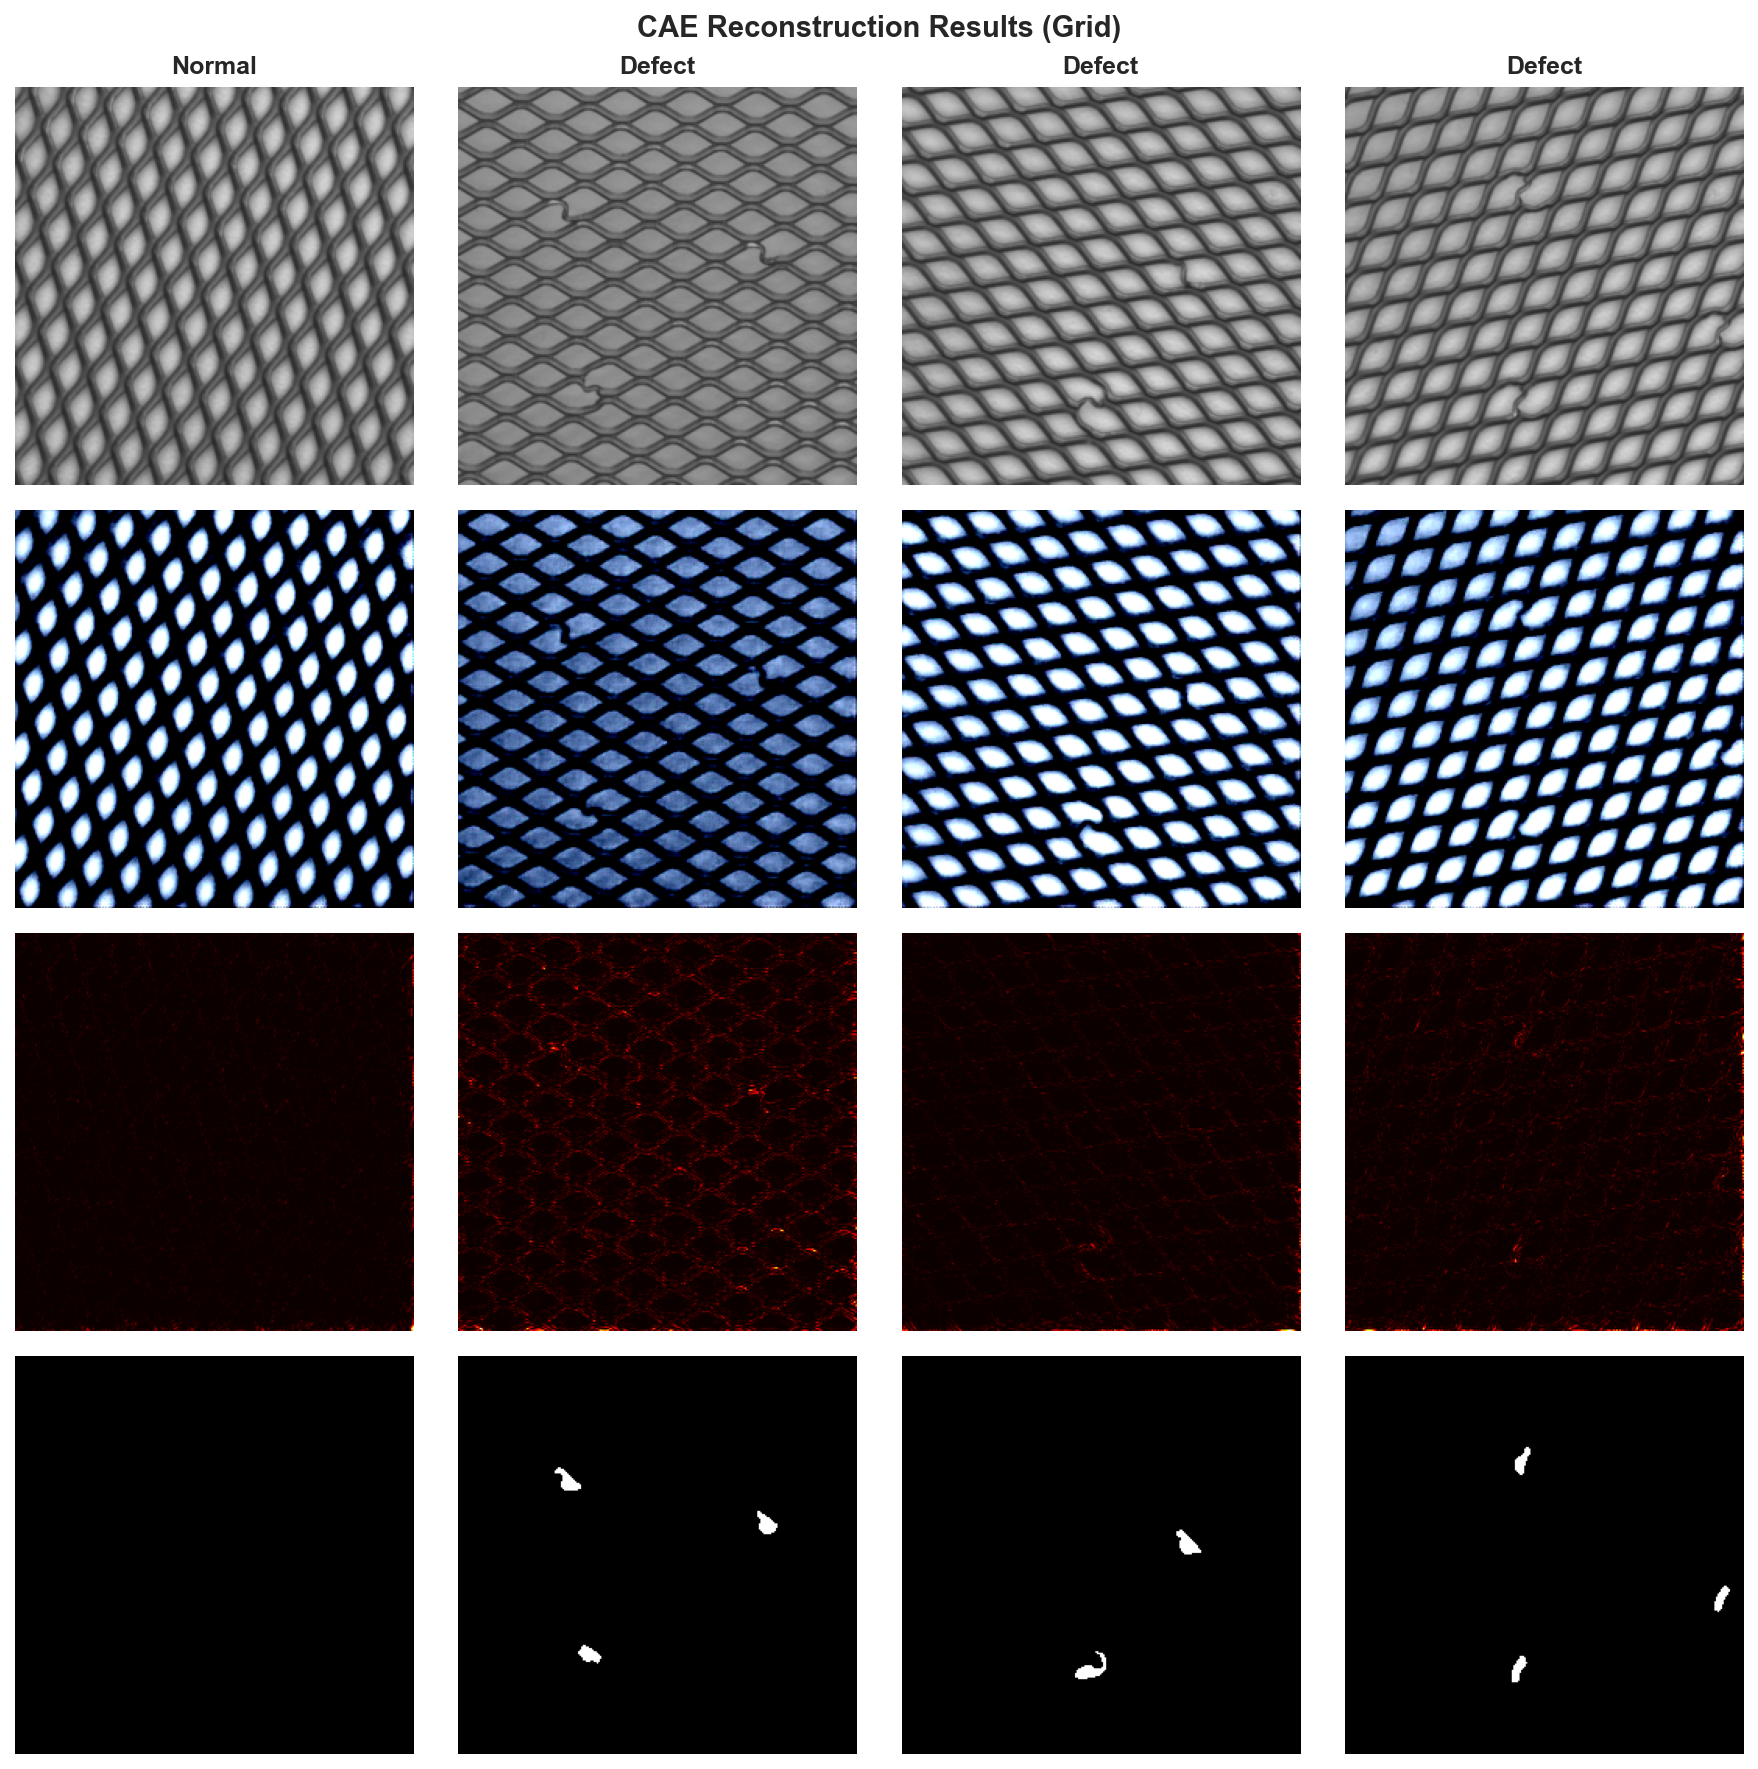

In [6]:
# Load best CAE model
category = 'grid'  # Best performing
cae_path = MODELS_DIR / f'cae_{category}_final.pth'

if cae_path.exists():
    cae = create_cae()
    cae.load_state_dict(torch.load(cae_path, map_location=DEVICE)['model_state_dict'])
    cae.eval()
    
    test_ds = MVTecDataset(category=category, split='test', return_mask=True)
    
    # Get 1 normal + 3 defect samples
    normal_idx = [i for i, l in enumerate(test_ds.labels) if l == 0][0]
    defect_indices = [i for i, l in enumerate(test_ds.labels) if l == 1][:3]
    sample_indices = [normal_idx] + defect_indices
    
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    row_labels = ['Original', 'Reconstruction', 'Error Map', 'Ground Truth']
    
    for col, idx in enumerate(sample_indices):
        img, mask, label = test_ds[idx]
        img_input = img.unsqueeze(0).to(DEVICE)
        
        with torch.no_grad():
            recon = cae(img_input)
            error = cae.get_anomaly_map(img_input)
        
        img_np = denormalize(img).permute(1, 2, 0).numpy().clip(0, 1)
        recon_np = recon[0].cpu().permute(1, 2, 0).numpy().clip(0, 1)
        error_np = error[0, 0].cpu().numpy()
        mask_np = mask[0].numpy()
        
        axes[0, col].imshow(img_np)
        axes[0, col].set_title('Normal' if label == 0 else 'Defect', fontweight='bold')
        axes[0, col].axis('off')
        
        axes[1, col].imshow(recon_np)
        axes[1, col].axis('off')
        
        axes[2, col].imshow(error_np, cmap='hot')
        axes[2, col].axis('off')
        
        axes[3, col].imshow(mask_np, cmap='gray')
        axes[3, col].axis('off')
    
    for row, label in enumerate(row_labels):
        axes[row, 0].set_ylabel(label, fontsize=11, fontweight='bold', rotation=90, labelpad=10)
    
    plt.suptitle(f'CAE Reconstruction Results ({category.title()})', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(FIGURES_DIR / 'thesis_fig4_reconstructions.png', dpi=300, bbox_inches='tight')
    plt.show()

## 6. Figure 5: Summary Statistics Table

In [7]:
# Create summary table
summary_data = []

for name, df in [('CAE', cae_df), ('VAE', vae_df), ('DAE', dae_df)]:
    if df is not None:
        valid_aucs = df['auc'].dropna()
        summary_data.append({
            'Model': name,
            'Mean AUC': f"{valid_aucs.mean():.3f}",
            'Std': f"{valid_aucs.std():.3f}",
            'Best': f"{valid_aucs.max():.3f}",
            'Worst': f"{valid_aucs.min():.3f}",
            'Categories > 0.6': int((valid_aucs > 0.6).sum()),
        })

# Add CNN classifier
cnn_path = MODELS_DIR / 'cnn_classifier_final.pth'
if cnn_path.exists():
    ckpt = torch.load(cnn_path, map_location='cpu')
    summary_data.append({
        'Model': 'CNN (Supervised)',
        'Mean AUC': f"{ckpt.get('accuracy', 0):.3f} (Acc)",
        'Std': '-',
        'Best': '-',
        'Worst': '-',
        'Categories > 0.6': 6,
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*60)
print("TABLE: Model Performance Summary")
print("="*60)
display(summary_df)

# Save as CSV
summary_df.to_csv(OUTPUTS_DIR / 'thesis_summary_table.csv', index=False)
print(f"\nSaved to: outputs/thesis_summary_table.csv")


TABLE: Model Performance Summary


,Model,Mean AUC,Std,Best,Worst,Categories > 0.6
0,VAE,0.476,0.198,1.000,0.238,3
1,DAE,0.621,0.240,0.986,0.268,7
2,CNN (Supervised),1.000 (Acc),-,-,-,6



Saved to: outputs/thesis_summary_table.csv


## 7. List All Generated Figures

In [8]:
print("="*60)
print("GENERATED THESIS FIGURES")
print("="*60)

thesis_figs = list(FIGURES_DIR.glob('thesis_*.png'))
for fig_path in sorted(thesis_figs):
    size_kb = fig_path.stat().st_size / 1024
    print(f"  {fig_path.name} ({size_kb:.0f} KB)")

print("\nAll figures saved at 300 DPI for publication quality.")

GENERATED THESIS FIGURES
  thesis_fig1_datasets.png (522 KB)
  thesis_fig3_generalization.png (199 KB)
  thesis_fig4_reconstructions.png (1375 KB)

All figures saved at 300 DPI for publication quality.
